# Moving Average Models for Forecasting

The residual errors from forecasts on a time series provide another source of information that we can model. Residual errors themselves form a time series that can have temporal structure. A simple autoregression model of this structure can be used to predict the forecast error, which
in turn can be used to correct forecasts. In this notebook, you will discover how to model a residual error time series and use it to correct predictions with Python.

In [1]:
data_path = './data/daily-total-female-births.csv'

In [2]:
# autoregressive model of residual errors
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AR
series = read_csv(data_path, header=0, index_col=0, parse_dates=True, squeeze=True)

In [3]:
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model on training set
train_pred = [x for x in train_X]

# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print('Lag=%d, Coef=%s' % (window, coef))

Lag=15, Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]


In [4]:
# forecast residual forecast error
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AR
from matplotlib import pyplot
series = read_csv(data_path, header=0, index_col=0, parse_dates=True, squeeze=True)

In [5]:
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model on training set
train_pred = [x for x in train_X]

# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
        predictions.append(pred_error)
        history.append(error)
        print('predicted error=%f, expected error=%f' % (pred_error, error))

predicted error=-0.748199, expected error=9.000000
predicted error=6.252326, expected error=9.000000
predicted error=4.785426, expected error=9.000000
predicted error=2.029343, expected error=9.000000
predicted error=-0.934184, expected error=9.000000
predicted error=-0.396512, expected error=9.000000
predicted error=2.156690, expected error=9.000000
predicted error=2.156690, expected error=9.000000
predicted error=0.558922, expected error=9.000000
predicted error=1.516162, expected error=9.000000
predicted error=0.301160, expected error=9.000000
predicted error=1.986629, expected error=9.000000
predicted error=1.853629, expected error=9.000000
predicted error=1.227839, expected error=9.000000
predicted error=1.155523, expected error=9.000000
predicted error=-7.543448, expected error=-10.000000
predicted error=-14.543973, expected error=-10.000000
predicted error=-21.145024, expected error=-10.000000
predicted error=-27.346209, expected error=-10.000000
predicted error=-32.680559, expe

predicted error=1.800019, expected error=-4.000000
predicted error=3.355691, expected error=-4.000000
predicted error=4.822592, expected error=-4.000000
predicted error=6.200633, expected error=-4.000000
predicted error=7.386044, expected error=-4.000000
predicted error=8.461389, expected error=-4.000000
predicted error=9.312457, expected error=-4.000000
predicted error=9.809681, expected error=-4.000000
predicted error=10.209123, expected error=-4.000000
predicted error=10.528204, expected error=-4.000000
predicted error=10.749113, expected error=-4.000000
predicted error=11.030025, expected error=-4.000000
predicted error=11.296024, expected error=-4.000000
predicted error=11.546340, expected error=-4.000000
predicted error=11.618656, expected error=-4.000000
predicted error=3.498832, expected error=-2.000000
predicted error=6.610176, expected error=-2.000000
predicted error=9.543976, expected error=-2.000000
predicted error=12.300059, expected error=-2.000000
predicted error=14.6708

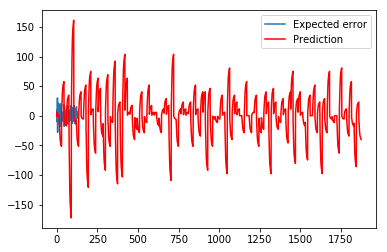

In [6]:
# plot predicted error
pyplot.plot(expected_error, label='Expected error')
pyplot.plot(predictions, color='red', label='Prediction')
pyplot.legend()
pyplot.show()

## Correct Predictions with a Model of Residuals

In [7]:
# correct the prediction
yhat = yhat + pred_error

In [8]:
# correct forecasts with a model of forecast residual errors
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AR
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# load data
series = read_csv(data_path, header=0, index_col=0, parse_dates=True, squeeze=True)

# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model on training set
train_pred = [x for x in train_X]

# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    # correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    print('predicted=%f, expected=%f' % (yhat, test_y[t]))
    
# error
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=43.155523, expected=51.000000
predicted=43.891191, expected=41.000000
predicted=44.007486, expected=44.000000
predicted=43.243554, expected=38.000000
predicted=43.511163, expected=68.000000
predicted=48.008736, expected=40.000000
predicted=44.842429, expected=42.000000
predicted=45.050883, expected=51.000000
predicted=45.858415, expected=44.000000
predicted=45.161119, expected=45.000000
predicted=44.758072, expected=36.000000
predicted=45.159826, expected=57.000000
predicted=49.882026, expected=44.000000
predicted=45.182992, expected=42.000000
predicted=44.769363, expected=53.000000
predicted=48.040663, expected=42.000000
predicted=44.566233, expected=34.000000
predicted=43.084498, expected=40.000000
predicted=43.020899, expected=56.000000
predicted=49.457902, expected=44.000000
predicted=45.328116, expected=53.000000
predicted=45.225588, expected=55.000000
predicted=48.705924, expected=39.000000
predicted=44.166344, expected=59.000000
predicted=45.621871, expected=55.000000


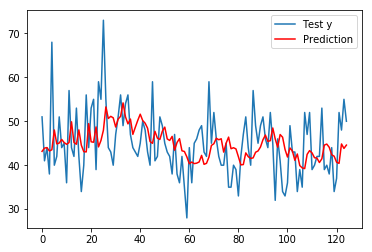

In [9]:
# plot predicted error
pyplot.plot(test_y, label='Test y')
pyplot.plot(predictions, color='red', label='Prediction')
pyplot.legend()
pyplot.show()

### References:
The website Data Market provides access to a large number of time series datasets. Specically, the Time Series Data Library (https://datamarket.com/data/list/?q=provider:tsdl) created by Rob Hyndman, Professor of Statistics at Monash University, Australia.